# Validation for Anisotropic SGS Model Trained on 3x and 6x Data

In [9]:
import numpy as np
from numpy import linalg as la
import math as m
import torch
import matplotlib.pyplot as plt
import evtk
import vtk
from vtk.util import numpy_support as VN

## Define SGS model class used for validation

In [10]:
# Define class for the model
class SGS:
    def __init__(self, data_path, model_path, crd_path=None, device="cpu"):
        self.data_path = data_path
        self.crd_path = crd_path
        self.model_path = model_path
        self.device = device
        self.test_data = None
        self.X = None
        self.y = None
        self.SGS = None
        self.crd = None
        self.model = None
        self.y_pred_glob = None
        self.min_val = np.zeros(6)
        self.max_val = np.zeros(6)
        self.eigvecs_aligned = None
        self.SpO = None
        self.Deltaij_norm = None
        self.SGS_GM = None
        self.new_outputs = None

    # Load model
    def load_model(self):
        self.model = torch.jit.load(self.model_path+"_jit.pt", 
                                    map_location=torch.device(self.device))
        tmp = np.loadtxt(self.model_path+"_scaling.txt")
        self.min_val = tmp[:,0]
        self.max_val = tmp[:,1]
        
    # Load inputs and outputs from file directly
    def load_data(self):
        extension = self.data_path.split(".")[-1]
        #if "npy" in extension:
        #    test_data = np.load(self.data_path)
        #    self.y = test_data[:,:6]
        #    self.X = test_data[:,6:]
        #    self.crd = np.load(self.crd_path)
        if "vtu" in extension or "vtk" in extension:
            from vtk.util import numpy_support as VN
            reader = vtk.vtkXMLUnstructuredGridReader()
            reader.SetFileName(self.data_path)
            reader.Update()
            output = reader.GetOutput()
            self.X = np.hstack((VN.vtk_to_numpy(output.GetPointData().GetArray("input123_py")),
                                VN.vtk_to_numpy(output.GetPointData().GetArray("input456_py"))))
            self.y = np.hstack((VN.vtk_to_numpy(output.GetPointData().GetArray("output123_py")),
                                VN.vtk_to_numpy(output.GetPointData().GetArray("output456_py"))))
            self.SGS = np.hstack((VN.vtk_to_numpy(output.GetPointData().GetArray("SGS_diag")),
                                  VN.vtk_to_numpy(output.GetPointData().GetArray("SGS_offdiag"))))
            self.crd = VN.vtk_to_numpy(output.GetPoints().GetData())
        return output
    
    # Compute inputs and outputs from raw data
    def compute_data(self, scaling, alignment="vorticity"):
        extension = self.data_path.split(".")[-1]
        if "vtu" in extension or "vtk" in extension:
            reader = vtk.vtkXMLUnstructuredGridReader()
            reader.SetFileName(self.data_path)
            reader.Update()
            polydata = reader.GetOutput()
            self.SGS = np.hstack((VN.vtk_to_numpy(polydata.GetPointData().GetArray("SGS_diag")),
                                  VN.vtk_to_numpy(polydata.GetPointData().GetArray("SGS_offdiag"))))
            self.crd = VN.vtk_to_numpy(polydata.GetPoints().GetData())
            GradU = np.hstack((VN.vtk_to_numpy(polydata.GetPointData().GetArray("GradUFilt")),
                            VN.vtk_to_numpy(polydata.GetPointData().GetArray("GradVFilt")),
                            VN.vtk_to_numpy(polydata.GetPointData().GetArray("GradZFilt"))))
            GradU = np.reshape(GradU, (-1,3,3))
            Delta = VN.vtk_to_numpy(polydata.GetPointData().GetArray("gij"))
            
        nsamples = GradU.shape[0]
        self.eigvecs_aligned = np.zeros((nsamples,3,3))
        self.SpO = np.zeros((nsamples,))
        self.Deltaij_norm = np.zeros((nsamples,))
        self.y = np.zeros((nsamples,6))
        self.X = np.zeros((nsamples,6))
        Deltaij = np.zeros((3,3))
        Sij = np.zeros((3,3))
        Oij = np.zeros((3,3))
        vort = np.zeros((3,))
        vort_Sframe = np.zeros((3,))
        tmp = np.zeros((3,3))
        for i in range(nsamples):
            Deltaij[0,0] = Delta[i,0]*scaling[0]
            Deltaij[1,1] = Delta[i,1]*scaling[1]
            Deltaij[2,2] = Delta[i,2]*scaling[2]
            self.Deltaij_norm[i] = m.sqrt(Deltaij[0,0]**2 + Deltaij[1,1]**2 + Deltaij[2,2]**2)
            Deltaij = Deltaij / (self.Deltaij_norm[i]+1.0e-14)
            
            Gij = np.matmul(GradU[i],Deltaij)
            Sij[0,0] = Gij[0,0]
            Sij[1,1] = Gij[1,1]
            Sij[2,2] = Gij[2,2]
            Sij[0,1] = 0.5*(Gij[0,1]+Gij[1,0])
            Sij[0,2] = 0.5*(Gij[0,2]+Gij[2,0])
            Sij[1,2] = 0.5*(Gij[1,2]+Gij[2,1])
            Sij[1,0] = Sij[0,1]
            Sij[2,0] = Sij[0,2]
            Sij[2,1] = Sij[1,2]
            Oij[0,1] = 0.5*(Gij[0,1]-Gij[1,0])
            Oij[0,2] = 0.5*(Gij[0,2]-Gij[2,0])
            Oij[1,2] = 0.5*(Gij[1,2]-Gij[2,1])
            Oij[1,0] = -Oij[0,1]
            Oij[2,0] = -Oij[0,2]
            Oij[2,1] = -Oij[1,2]
            vort[0] = -2*Oij[1,2]
            vort[1] = -2*Oij[0,2]
            vort[2] = -2*Oij[0,1]
            Sij_norm = m.sqrt(Sij[0,0]**2+Sij[1,1]**2+Sij[2,2]**2 \
                          + 2*(Sij[0,1]**2+Sij[0,2]**2+Sij[1,2]**2))
            vort_norm = m.sqrt(vort[0]**2 + vort[1]**2 + vort[2]**2)
            self.SpO[i] = Sij_norm**2 + 0.5*vort_norm**2
            
            #evals, evecs = jacobi(Sij) 
            evals, evecs = la.eig(Sij)
            if (alignment=="vorticity"):
                vec = vort.copy()
            elif (alignment=="wall-normal"):
                vec = np.array([0,1,0])
            else:
                print("Alignment option not known, used default vorticity alignment")
                vec = vort.copy()
            lda, eigvecs, self.eigvecs_aligned[i] = self.align_tensors(evals,evecs,vec)
            
            vort_Sframe[0] = np.dot(vort,self.eigvecs_aligned[i,:,0])
            vort_Sframe[1] = np.dot(vort,self.eigvecs_aligned[i,:,1])
            vort_Sframe[2] = np.dot(vort,self.eigvecs_aligned[i,:,2])
            self.X[i,0] = lda[0] / (m.sqrt(self.SpO[i])+1.0e-14)
            self.X[i,1] = lda[1] / (m.sqrt(self.SpO[i])+1.0e-14)
            self.X[i,2] = lda[2] / (m.sqrt(self.SpO[i])+1.0e-14)
            self.X[i,3] = vort_Sframe[0] / (m.sqrt(self.SpO[i])+1.0e-14)
            self.X[i,4] = vort_Sframe[1] / (m.sqrt(self.SpO[i])+1.0e-14)
            self.X[i,5] = 1.25e-5 / (self.Deltaij_norm[i]**2 * m.sqrt(self.SpO[i]) + 1.0e-14)
        
            tmp[0,0] = self.SGS[i,0] / (self.Deltaij_norm[i]**2 * self.SpO[i] + 1.0e-14)
            tmp[1,1] = self.SGS[i,1] / (self.Deltaij_norm[i]**2 * self.SpO[i] + 1.0e-14)
            tmp[2,2] = self.SGS[i,2] / (self.Deltaij_norm[i]**2 * self.SpO[i] + 1.0e-14)
            tmp[0,1] = self.SGS[i,3] / (self.Deltaij_norm[i]**2 * self.SpO[i] + 1.0e-14)
            tmp[0,2] = self.SGS[i,4] / (self.Deltaij_norm[i]**2 * self.SpO[i] + 1.0e-14)
            tmp[1,2] = self.SGS[i,5] / (self.Deltaij_norm[i]**2 * self.SpO[i] + 1.0e-14)
            tmp[1,0] = tmp[0,1]
            tmp[2,0] = tmp[0,2]
            tmp[2,1] = tmp[1,2]
            tmp = np.matmul(np.transpose(self.eigvecs_aligned[i]),
                           np.matmul(tmp,self.eigvecs_aligned[i]))
            self.y[i,0] = tmp[0,0]
            self.y[i,1] = tmp[1,1]
            self.y[i,2] = tmp[2,2]
            self.y[i,3] = tmp[0,1]
            self.y[i,4] = tmp[0,2]
            self.y[i,5] = tmp[1,2]
            
        return polydata

    # Undo the model's min-max scaling
    def undo_min_max(self,y):
        for i in range(6):
            y[:,i] = y[:,i] * (self.max_val[i] - self.min_val[i]) + self.min_val[i]
        return y

    # Deine MSE function
    def MSE(self, y, y_pred):
        glob_mse = np.square(y-y_pred).mean()
        channel_mse = np.zeros((6,))
        for i in range(6):
            tmp = np.square(y[:,i]-y_pred[:,i]).mean()
            channel_mse[i] = tmp
        return glob_mse, channel_mse
    
    # Define Relative Root MSE function
    def RRMSE(self,y,y_pred):
        #glob_rrmse = m.sqrt(np.square(y-y_pred).mean())/(np.std(y)+1.0e-14)
        glob_rrmse = m.sqrt(np.square(y-y_pred).mean())/abs(np.mean(y)+1.0e-14)
        channel_rrmse = np.zeros((6,))
        for i in range(6):
            #tmp = m.sqrt(np.square(y[:,i]-y_pred[:,i]).mean())/(np.std(y[:,i])+1.0e-14)
            tmp = m.sqrt(np.square(y[:,i]-y_pred[:,i]).mean())/abs(np.mean(y[:,i])+1.0e-14)
            channel_rrmse[i] = tmp
        return glob_rrmse, channel_rrmse
    
    # Define Correlation Coefficient function
    def CC(self, y, y_pred):
        glob_cc = np.corrcoef([np.ndarray.flatten(y),np.ndarray.flatten(y_pred)])[0][1]
        channel_cc = np.zeros((6,))
        for i in range(6):
            tmp = np.corrcoef([y[:,i],y_pred[:,i]])[0][1]
            channel_cc[i] = tmp
        return glob_cc, channel_cc

    # Align the eigenvalues and eignevectors according to the local vorticity
    def align_tensors(self,evals,evecs,vec):
        if (evals[0]<1.0e-8 and evals[1]<1.0e-8 and evals[2]<1.0e-8):
            index = [0,1,2]
        else:
            index = np.flip(np.argsort(evals))
        lda = evals[index]
        vec_norm = m.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)
        vec = vec/vec_norm
        eigvec = np.zeros((3,3))
        eigvec[:,0] = evecs[:,index[0]]
        eigvec[:,1] = evecs[:,index[1]]
        eigvec[:,2] = evecs[:,index[2]]
        eigvec_vort_aligned = eigvec.copy()
        if (np.dot(vec,eigvec_vort_aligned[:,0]) < np.dot(vec,-eigvec_vort_aligned[:,0])):
            eigvec_vort_aligned[:,0] = -eigvec_vort_aligned[:,0]
        if (np.dot(vec,eigvec_vort_aligned[:,2]) < np.dot(vec,-eigvec_vort_aligned[:,2])):
            eigvec_vort_aligned[:,2] = -eigvec_vort_aligned[:,2]
        eigvec_vort_aligned[0,1] = (eigvec_vort_aligned[1,2]*eigvec_vort_aligned[2,0]) \
                               - (eigvec_vort_aligned[2,2]*eigvec_vort_aligned[1,0])
        eigvec_vort_aligned[1,1] = (eigvec_vort_aligned[2,2]*eigvec_vort_aligned[0,0]) \
                               - (eigvec_vort_aligned[0,2]*eigvec_vort_aligned[2,0])
        eigvec_vort_aligned[2,1] = (eigvec_vort_aligned[0,2]*eigvec_vort_aligned[1,0]) \
                               - (eigvec_vort_aligned[1,2]*eigvec_vort_aligned[0,0])
        return lda, eigvec, eigvec_vort_aligned

    # Compute the transformation needed to obtain the physical stresses
    def compute_transformation(self, polydata, scaling, alignment="vorticity"):
        GradU = np.hstack((VN.vtk_to_numpy(polydata.GetPointData().GetArray("GradUFilt")),
                            VN.vtk_to_numpy(polydata.GetPointData().GetArray("GradVFilt")),
                            VN.vtk_to_numpy(polydata.GetPointData().GetArray("GradZFilt"))))
        GradU = np.reshape(GradU, (-1,3,3))
        Delta = VN.vtk_to_numpy(polydata.GetPointData().GetArray("gij"))
        nsamples = GradU.shape[0]
        self.eigvecs_aligned = np.zeros((nsamples,3,3))
        self.SpO = np.zeros((nsamples,))
        self.Deltaij_norm = np.zeros((nsamples,))
        Deltaij = np.zeros((3,3))
        Sij = np.zeros((3,3))
        Oij = np.zeros((3,3))
        vort = np.zeros((3,))
        for i in range(nsamples):
            Deltaij[0,0] = Delta[i,0]*scaling[0]
            Deltaij[1,1] = Delta[i,1]*scaling[1]
            Deltaij[2,2] = Delta[i,2]*scaling[2]
            self.Deltaij_norm[i] = m.sqrt(Deltaij[0,0]**2 + Deltaij[1,1]**2 + Deltaij[2,2]**2)
            Deltaij = Deltaij / (self.Deltaij_norm[i]+1.0e-14)
            Gij = np.matmul(GradU[i],Deltaij)
            Sij[0,0] = Gij[0,0]
            Sij[1,1] = Gij[1,1]
            Sij[2,2] = Gij[2,2]
            Sij[0,1] = 0.5*(Gij[0,1]+Gij[1,0])
            Sij[0,2] = 0.5*(Gij[0,2]+Gij[2,0])
            Sij[1,2] = 0.5*(Gij[1,2]+Gij[2,1])
            Sij[1,0] = Sij[0,1]
            Sij[2,0] = Sij[0,2]
            Sij[2,1] = Sij[1,2]
            Oij[0,1] = 0.5*(Gij[0,1]-Gij[1,0])
            Oij[0,2] = 0.5*(Gij[0,2]-Gij[2,0])
            Oij[1,2] = 0.5*(Gij[1,2]-Gij[2,1])
            Oij[1,0] = -Oij[0,1]
            Oij[2,0] = -Oij[0,2]
            Oij[2,1] = -Oij[1,2]
            vort[0] = -2*Oij[1,2]
            vort[1] = -2*Oij[0,2]
            vort[2] = -2*Oij[0,1]
            Sij_norm = m.sqrt(Sij[0,0]**2+Sij[1,1]**2+Sij[2,2]**2 \
                          + 2*(Sij[0,1]**2+Sij[0,2]**2+Sij[1,2]**2))
            vort_norm = m.sqrt(vort[0]**2 + vort[1]**2 + vort[2]**2)
            self.SpO[i] = Sij_norm**2 + 0.5*vort_norm**2
            #evals, evecs = jacobi(Sij) 
            evals, evecs = la.eig(Sij)
            if (alignment=="vorticity"):
                vec = vort.copy()
            elif (alignment=="wall-normal"):
                vec = np.array([0,1,0])
            else:
                print("Alignment option not known, used default vorticity alignment")
                vec = vort.copy()
            lda, eigvecs, self.eigvecs_aligned[i] = self.align_tensors(evals,evecs,vec)

    # Compute physical stresses
    def compute_SGS(self,y,index=None):
        if (index is not None):
            nsamples = y.shape[0]
        else:
            nsamples = y.shape[0]
            index = range(nsamples)
        SGS_pred = np.zeros((nsamples,6))
        tmp = np.zeros((3,3))
        for i in range(nsamples):
            tmp[0,0] = y[i,0]
            tmp[1,1] = y[i,1]
            tmp[2,2] = y[i,2]
            tmp[0,1] = y[i,3]
            tmp[0,2] = y[i,4]
            tmp[1,2] = y[i,5]
            tmp[1,0] = tmp[0,1]
            tmp[2,0] = tmp[0,2]
            tmp[2,1] = tmp[1,2]
            evecs = self.eigvecs_aligned[index[i]].copy()
            tmp = np.matmul(evecs,tmp)
            tmp = np.matmul(tmp,np.transpose(evecs))
            SGS_pred[i,0] = tmp[0,0] * (self.Deltaij_norm[index[i]]**2 * self.SpO[index[i]])
            SGS_pred[i,1] = tmp[1,1] * (self.Deltaij_norm[index[i]]**2 * self.SpO[index[i]])
            SGS_pred[i,2] = tmp[2,2] * (self.Deltaij_norm[index[i]]**2 * self.SpO[index[i]])
            SGS_pred[i,3] = tmp[0,1] * (self.Deltaij_norm[index[i]]**2 * self.SpO[index[i]])
            SGS_pred[i,4] = tmp[0,2] * (self.Deltaij_norm[index[i]]**2 * self.SpO[index[i]])
            SGS_pred[i,5] = tmp[1,2] * (self.Deltaij_norm[index[i]]**2 * self.SpO[index[i]])
        return SGS_pred
    
    # Run inference on all data for global metrics
    def test_global(self, X_test=None, y_test=None):
        if X_test and y_test:
            X = X_test; y = y_test
        else:
            X = self.X; y = self.y; SGS = self.SGS
        X_torch = torch.from_numpy(np.float32(X))
        self.y_pred_glob = self.model(X_torch).detach().numpy()
        self.y_pred_glob = self.undo_min_max(self.y_pred_glob)
        mse_glob, mse_channel = self.MSE(y,self.y_pred_glob)
        cc_glob, cc_channel = self.CC(y,self.y_pred_glob)
        print("Inference on global data:")
        print(f"Output global MSE = {mse_glob:>8e}")
        print(f"Output channel MSE = {mse_channel[0]:>8e} {mse_channel[1]:>8e} {mse_channel[2]:>8e} {mse_channel[3]:>8e} {mse_channel[4]:>8e} {mse_channel[5]:>8e}")
        print(f"Output global Corr. Coefficient = {cc_glob:>8e}")
        print(f"Output channel Corr. Coefficient = {cc_channel[0]:>8e} {cc_channel[1]:>8e} {cc_channel[2]:>8e} {cc_channel[3]:>8e} {cc_channel[4]:>8e} {cc_channel[5]:>8e}")
        self.SGS_pred_glob = self.compute_SGS(self.y_pred_glob)
        mse_glob, mse_channel = self.MSE(SGS,self.SGS_pred_glob)
        rrmse_glob, rrmse_channel = self.RRMSE(SGS,self.SGS_pred_glob)
        cc_glob, cc_channel = self.CC(SGS,self.SGS_pred_glob)
        print(f"SGS global MSE = {mse_glob:>8e}")
        print(f"SGS channel MSE = {mse_channel[0]:>8e} {mse_channel[1]:>8e} {mse_channel[2]:>8e} {mse_channel[3]:>8e} {mse_channel[4]:>8e} {mse_channel[5]:>8e}")
        print(f"SGS global RRMSE = {rrmse_glob:>8e}")
        print(f"SGS channel RRMSE = {rrmse_channel[0]:>8e} {rrmse_channel[1]:>8e} {rrmse_channel[2]:>8e} {rrmse_channel[3]:>8e} {rrmse_channel[4]:>8e} {rrmse_channel[5]:>8e}")
        print(f"SGS global Corr. Coefficient = {cc_glob:>8e}")
        print(f"SGS channel Corr. Coefficient = {cc_channel[0]:>8e} {cc_channel[1]:>8e} {cc_channel[2]:>8e} {cc_channel[3]:>8e} {cc_channel[4]:>8e} {cc_channel[5]:>8e}")
        print("")
        
    # Run inference one 1 wall-parallel layer at a time
    def test_y_layers(self, X_test=None, y_test=None, crd_test=None):
        if X_test and y_test and crd_test:
            X = X_test; y = y_test; crd = crd_test
        else:
            X = self.X; y = self.y; crd = self.crd; SGS = self.SGS
        crd_y = np.unique(crd[:,1])
        ny = 150 #crd_y.size
        crd_y = crd_y[:ny]
        mse_y = np.zeros((ny,)); mse_channel_y = np.zeros((ny,6))
        rrmse_y = np.zeros((ny,)); rrmse_channel_y = np.zeros((ny,6))
        cc_y = np.zeros((ny,)); cc_channel_y = np.zeros((ny,6))
        for j in range(ny):
            index = np.where(crd[:,1]==crd_y[j])[0]
            X_tmp = torch.from_numpy(np.float32(X[index]))
            y_pred_tmp = self.model(X_tmp).detach().numpy()
            y_pred_tmp = self.undo_min_max(y_pred_tmp)
            SGS_pred_tmp = self.compute_SGS(y_pred_tmp, index=index)
            mse_y[j], mse_channel_y[j] = self.MSE(SGS[index],SGS_pred_tmp)
            rrmse_y[j], rrmse_channel_y[j] = self.RRMSE(SGS[index],SGS_pred_tmp)
            cc_y[j], cc_channel_y[j] = self.CC(SGS[index],SGS_pred_tmp)
        return crd_y, [mse_y, mse_channel_y], [rrmse_y, rrmse_channel_y], [cc_y, cc_channel_y]

    # Compute the stress with the Gradient Model
    def gradient_SGS_model(self, polydata, scaling):
        GradU = np.hstack((VN.vtk_to_numpy(polydata.GetPointData().GetArray("GradUFilt")),
                            VN.vtk_to_numpy(polydata.GetPointData().GetArray("GradVFilt")),
                            VN.vtk_to_numpy(polydata.GetPointData().GetArray("GradZFilt"))))
        GradU = np.reshape(GradU, (-1,3,3))
        Delta = VN.vtk_to_numpy(polydata.GetPointData().GetArray("gij"))
        Delta[:,0] = Delta[:,0]*scaling[0]
        Delta[:,1] = Delta[:,1]*scaling[1]
        Delta[:,2] = Delta[:,2]*scaling[2]
        nsamples = GradU.shape[0]
        self.SGS_GM = np.zeros((nsamples,6))
        for i in range(nsamples):
            self.SGS_GM[i,0] = (Delta[i,0]**2 * GradU[i,0,0]**2 + \
                                Delta[i,1]**2 * GradU[i,0,1]**2 + \
                                Delta[i,2]**2 * GradU[i,0,2]**2) / 12 # 11
            self.SGS_GM[i,1] = (Delta[i,0]**2 * GradU[i,1,0]**2 + \
                                Delta[i,1]**2 * GradU[i,1,1]**2 + \
                                Delta[i,2]**2 * GradU[i,1,2]**2) / 12 # 22
            self.SGS_GM[i,2] = (Delta[i,0]**2 * GradU[i,2,0]**2 + \
                                Delta[i,1]**2 * GradU[i,2,1]**2 + \
                                Delta[i,2]**2 * GradU[i,2,2]**2) / 12 # 33
            self.SGS_GM[i,3] = (Delta[i,0]**2 * GradU[i,0,0]*GradU[i,1,0] + \
                                Delta[i,1]**2 * GradU[i,0,1]*GradU[i,1,1] + \
                                Delta[i,2]**2 * GradU[i,0,2]*GradU[i,1,2]) / 12 # 12
            self.SGS_GM[i,4] = (Delta[i,0]**2 * GradU[i,0,0]*GradU[i,2,0] + \
                                Delta[i,1]**2 * GradU[i,0,1]*GradU[i,2,1] + \
                                Delta[i,2]**2 * GradU[i,0,2]*GradU[i,2,2]) / 12 # 13
            self.SGS_GM[i,5] = (Delta[i,0]**2 * GradU[i,1,0]*GradU[i,2,0] + \
                                Delta[i,1]**2 * GradU[i,1,1]*GradU[i,2,1] + \
                                Delta[i,2]**2 * GradU[i,1,2]*GradU[i,2,2]) / 12 # 23
        print("Gradient Model on global data:")
        mse_glob, mse_channel = self.MSE(self.SGS,self.SGS_GM)
        rrmse_glob, rrmse_channel = self.RRMSE(self.SGS,self.SGS_GM)
        cc_glob, cc_channel = self.CC(self.SGS,self.SGS_GM)
        print(f"SGS global MSE = {mse_glob:>8e}")
        print(f"SGS channel MSE = {mse_channel[0]:>8e} {mse_channel[1]:>8e} {mse_channel[2]:>8e} {mse_channel[3]:>8e} {mse_channel[4]:>8e} {mse_channel[5]:>8e}")
        print(f"SGS global RRMSE = {rrmse_glob:>8e}")
        print(f"SGS channel RRMSE = {rrmse_channel[0]:>8e} {rrmse_channel[1]:>8e} {rrmse_channel[2]:>8e} {rrmse_channel[3]:>8e} {rrmse_channel[4]:>8e} {rrmse_channel[5]:>8e}")
        print(f"SGS global Corr. Coefficient = {cc_glob:>8e}")
        print(f"SGS channel Corr. Coefficient = {cc_channel[0]:>8e} {cc_channel[1]:>8e} {cc_channel[2]:>8e} {cc_channel[3]:>8e} {cc_channel[4]:>8e} {cc_channel[5]:>8e}")
        print("")
        
        crd_y = np.unique(self.crd[:,1])
        ny = 150 #crd_y.size
        crd_y = crd_y[:ny]
        mse_y = np.zeros((ny,)); mse_channel_y = np.zeros((ny,6))
        rrmse_y = np.zeros((ny,)); rrmse_channel_y = np.zeros((ny,6))
        cc_y = np.zeros((ny,)); cc_channel_y = np.zeros((ny,6))
        for j in range(ny):
            index = np.where(self.crd[:,1]==crd_y[j])[0]
            mse_y[j], mse_channel_y[j] = self.MSE(self.SGS[index],self.SGS_GM[index])
            rrmse_y[j], rrmse_channel_y[j] = self.RRMSE(self.SGS[index],self.SGS_GM[index])
            cc_y[j], cc_channel_y[j] = self.CC(self.SGS[index],self.SGS_GM[index])
        return crd_y, [mse_y, mse_channel_y], [rrmse_y, rrmse_channel_y], [cc_y, cc_channel_y]
        
    # Save to vtk files for import into Paraview
    def save_vtk(self, polydata, fname):
        from vtk.numpy_interface import dataset_adapter as dsa
        new = dsa.WrapDataObject(polydata)
        new.PointData.append(self.X[:,:3], "X123")
        new.PointData.append(self.X[:,3:], "X456")
        new.PointData.append(self.y[:,:3], "y123")
        new.PointData.append(self.y[:,3:], "y456")
        new.PointData.append(self.y_pred_glob[:,:3], "pred_output123")
        new.PointData.append(self.y_pred_glob[:,3:], "pred_output456")
        new.PointData.append(self.SGS_pred_glob[:,:3], "pred_SGS_diag")
        new.PointData.append(self.SGS_pred_glob[:,3:], "pred_SGS_offdiag")
        if (self.SGS_GM is not None):
            new.PointData.append(self.SGS_GM[:,:3], "SGSGM_diag")
            new.PointData.append(self.SGS_GM[:,3:], "SGSGM_offdiag")
        writer = vtk.vtkXMLUnstructuredGridWriter()
        writer.SetFileName(fname)
        writer.SetInputData(new.VTKObject)
        writer.Write()

## Validation on 3x Data

In [ ]:
base_path = "/Users/rbalin/Documents/Research/ALCF_PostDoc/Conferences/PASC23/FlatPlate/Train/CRS_6-15_4d/"
data_path = base_path+"validation_data_noDamp_jacobi/FlatPlate_ReTheta1000_6-15_ts29255_3x_noDamp_jacobi_test.vtu"
model_path = "/Users/rbalin/git-balin/data_driven_SGS_modeling/models/HIT/NNmodel_HIT"
scaling = [3, 3, 3]
HIT_3 = SGS(data_path, model_path)
HIT_3.load_model()
polydata = HIT_3.compute_data(scaling)
HIT_3.test_global()
crd_y, mse_y_GM_3, rrmse_y_GM_3, cc_y_GM_3 = HIT_3.gradient_SGS_model(polydata,scaling)
crd_y, mse_y_HIT_3, rrmse_y_HIT_3, cc_y_HIT_3 = HIT_3.test_y_layers()
#HIT.save_vtk(polydata,model_path+"_predictions.vtu")

model_path = base_path+"models/3n6/NNmodel"
base_3 = SGS(data_path, model_path)
base_3.load_model()
polydata = base_3.compute_data(scaling)
#polydata = base.load_data()
#base.compute_transformation(polydata,scaling)
base_3.test_global()
#base.gradient_SGS_model(polydata,scaling)
crd_y, mse_y_base_3, rrmse_y_base_3, cc_y_base_3 =  base_3.test_y_layers()
#base.save_vtk(polydata,model_path+"_predictions.vtu")

Inference on global data:
Output global MSE = 5.598897e-03
Output channel MSE = 9.147090e-03 4.769775e-03 1.090089e-02 1.817531e-03 5.402932e-03 1.555162e-03
Output global Corr. Coefficient = 4.989378e-01
Output channel Corr. Coefficient = 3.018467e-01 2.498152e-01 3.285645e-01 8.243977e-02 1.683362e-02 1.534413e-01
SGS global MSE = 4.542191e-07
SGS channel MSE = 1.524802e-06 1.449360e-07 5.593679e-07 8.698771e-08 3.634316e-07 4.578971e-08
SGS global RRMSE = 3.326259e+00
SGS channel RRMSE = 1.543519e+00 1.956329e+00 2.342412e+00 3.104847e+00 7.308474e+01 4.241423e+01
SGS global Corr. Coefficient = 5.560508e-01
SGS channel Corr. Coefficient = 7.625698e-01 6.584542e-01 4.824165e-01 3.748563e-01 -4.581146e-01 1.240547e-01

Gradient Model on global data:
SGS global MSE = 2.798981e-07
SGS channel MSE = 1.260637e-06 1.102773e-07 1.877980e-07 4.157644e-08 6.286999e-08 1.622929e-08
SGS global RRMSE = 2.611099e+00
SGS channel RRMSE = 1.403461e+00 1.706463e+00 1.357251e+00 2.146520e+00 3.039744e

In [ ]:
nu = 1.25e-5
uTau = 0.045
yplus = crd_y*uTau/nu
delta = 0.15*uTau/nu
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
axs.plot(yplus, mse_y_GM_3[0], 'd', label="GM")
axs.plot(yplus, mse_y_HIT_3[0], 's', label="HIT")
axs.plot(yplus, mse_y_base_3[0], 'o', label="base")
axs.plot([delta, delta], [1.0e-14, 100], 'k--', label="$\delta$")
axs.set_yscale("log")
axs.set_xscale("log")
axs.grid()
fig.tight_layout(pad=3.0)
axs.set_ylabel('MSE')
axs.set_xlabel('$y^+$')
axs.set_title('Mean Squared Error')
axs.legend()
axs.set_ylim(bottom=1.0e-11, top=1.0e-5)
axs.set_xlim(left=0.1, right=1000)
#plt.savefig(fig_name+"_yerrors.png", dpi='figure', format="png")
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
axs.plot(yplus, rrmse_y_GM_3[0], 'd', label="GM")
axs.plot(yplus, rrmse_y_HIT_3[0], 's', label="HIT")
axs.plot(yplus, rrmse_y_base_3[0], 'o', label="base")
axs.plot([delta, delta], [0, 10], 'k--', label="$\delta$")
#axs.set_yscale("log")
axs.set_xscale("log")
axs.grid()
fig.tight_layout(pad=3.0)
axs.set_ylabel('RRMSE')
axs.set_xlabel('$y^+$')
axs.set_title('Relative Root Mean Squared Error')
axs.legend()
axs.set_ylim(bottom=0, top=4)
axs.set_xlim(left=0.1, right=1000)
#plt.savefig(fig_name+"_yerrors.png", dpi='figure', format="png")
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
axs.plot(yplus, cc_y_GM_3[0], 'd', label="GM")
axs.plot(yplus, cc_y_HIT_3[0], 's', label="HIT")
axs.plot(yplus, cc_y_base_3[0], 'o', label="base")
axs.plot([delta, delta], [0, 1], 'k--', label="$\delta$")
#axs.set_yscale("log")
axs.set_xscale("log")
axs.grid()
fig.tight_layout(pad=3.0)
axs.set_ylabel('CC')
axs.set_xlabel('$y^+$')
axs.set_title('Correlation Coefficient')
axs.legend()
axs.set_ylim(bottom=0, top=1)
axs.set_xlim(left=0.1, right=1000)
#plt.savefig(fig_name+"_yerrors.png", dpi='figure', format="png")
plt.show()

## Validation on 6x Data

In [131]:
base_path = "/Users/rbalin/Documents/Research/ALCF_PostDoc/Conferences/PASC23/FlatPlate/Train/CRS_6-15_4d/"
data_path = base_path+"validation_data_noDamp_jacobi/FlatPlate_ReTheta1000_6-15_ts29255_6x_noDamp_jacobi_test.vtu"
model_path = "/Users/rbalin/git-balin/data_driven_SGS_modeling/models/HIT/NNmodel_HIT"
scaling = [6, 6, 6]
HIT_6 = SGS(data_path, model_path)
HIT_6.load_model()
polydata = HIT_6.compute_data(scaling)
HIT_6.test_global()
crd_y, mse_y_GM_6, rrmse_y_GM_6, cc_y_GM_6 = HIT_6.gradient_SGS_model(polydata,scaling)
crd_y, mse_y_HIT_6, rrmse_y_HIT_6, cc_y_HIT_6 = HIT_6.test_y_layers()
#HIT.save_vtk(polydata,model_path+"_predictions.vtu")

model_path = base_path+"models/all/NNmodel"
base_6 = SGS(data_path, model_path)
base_6.load_model()
polydata = base_6.compute_data(scaling)
#polydata = base.load_data()
#base.compute_transformation(polydata,scaling)
base_6.test_global()
#base.gradient_SGS_model(polydata,scaling)
crd_y, mse_y_base_6, rrmse_y_base_6, cc_y_base_6 =  base_6.test_y_layers()
#base.save_vtk(polydata,model_path+"_predictions.vtu")

Inference on global data:
Output global MSE = 9.618863e-03
Output channel MSE = 1.866701e-02 8.658956e-03 1.884764e-02 2.459630e-03 6.859937e-03 2.220009e-03
Output global Corr. Coefficient = 5.261591e-01
Output channel Corr. Coefficient = 1.235442e-01 2.216545e-01 1.907224e-01 1.746676e-01 3.026790e-01 1.716780e-01
SGS global MSE = 1.613048e-06
SGS channel MSE = 5.180355e-06 9.463909e-07 2.268563e-06 2.496646e-07 9.306017e-07 1.027137e-07
SGS global RRMSE = 2.725231e+00
SGS channel RRMSE = 1.159844e+00 2.561612e+00 2.176086e+00 -2.153001e+00 -3.905836e+01 1.712866e+01
SGS global Corr. Coefficient = 6.176723e-01
SGS channel Corr. Coefficient = 8.195617e-01 5.507780e-01 5.541421e-01 3.816550e-01 -3.062860e-01 1.373456e-01

Gradient Model on global data:
SGS global MSE = 1.333864e-06
SGS channel MSE = 6.429359e-06 3.537204e-07 8.253239e-07 1.531398e-07 1.998514e-07 4.179003e-08
SGS global RRMSE = 2.478195e+00
SGS channel RRMSE = 1.292122e+00 1.566059e+00 1.312541e+00 -1.686203e+00 -1.810

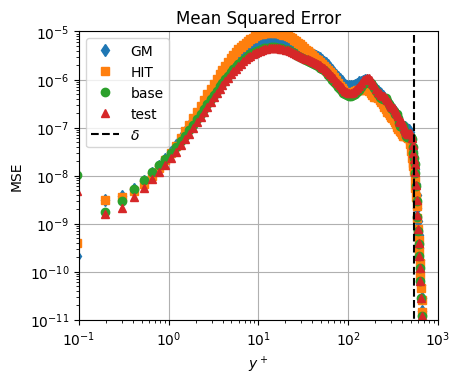

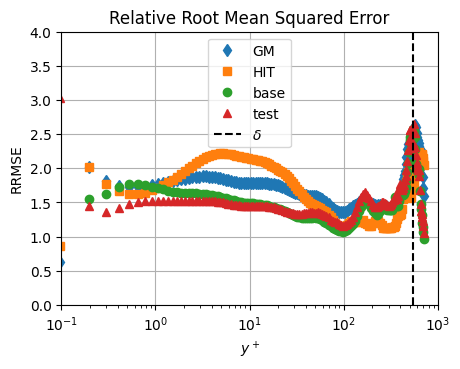

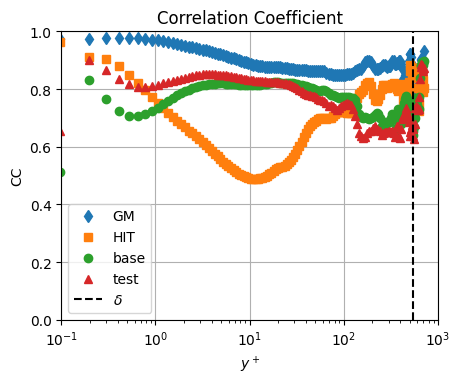

In [132]:
nu = 1.25e-5
uTau = 0.045
yplus = crd_y*uTau/nu
delta = 0.15*uTau/nu
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
axs.plot(yplus, mse_y_GM_6[0], 'd', label="GM")
axs.plot(yplus, mse_y_HIT_3_6[0], 's', label="HIT")
axs.plot(yplus, mse_y_base_3_6[0], 'o', label="base")
axs.plot(yplus, mse_y_test_3_6[0], '^', label="test")
axs.plot([delta, delta], [1.0e-14, 100], 'k--', label="$\delta$")
axs.set_yscale("log")
axs.set_xscale("log")
axs.grid()
fig.tight_layout(pad=3.0)
axs.set_ylabel('MSE')
axs.set_xlabel('$y^+$')
axs.set_title('Mean Squared Error')
axs.legend()
axs.set_ylim(bottom=1.0e-11, top=1.0e-5)
axs.set_xlim(left=0.1, right=1000)
#plt.savefig(fig_name+"_yerrors.png", dpi='figure', format="png")
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
axs.plot(yplus, rrmse_y_GM_6[0], 'd', label="GM")
axs.plot(yplus, rrmse_y_HIT_3_6[0], 's', label="HIT")
axs.plot(yplus, rrmse_y_base_3_6[0], 'o', label="base")
axs.plot(yplus, rrmse_y_test_3_6[0], '^', label="test")
axs.plot([delta, delta], [0, 10], 'k--', label="$\delta$")
#axs.set_yscale("log")
axs.set_xscale("log")
axs.grid()
fig.tight_layout(pad=3.0)
axs.set_ylabel('RRMSE')
axs.set_xlabel('$y^+$')
axs.set_title('Relative Root Mean Squared Error')
axs.legend()
axs.set_ylim(bottom=0, top=4)
axs.set_xlim(left=0.1, right=1000)
#plt.savefig(fig_name+"_yerrors.png", dpi='figure', format="png")
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
axs.plot(yplus, cc_y_GM_6[0], 'd', label="GM")
axs.plot(yplus, cc_y_HIT_3_6[0], 's', label="HIT")
axs.plot(yplus, cc_y_base_3_6[0], 'o', label="base")
axs.plot(yplus, cc_y_test_3_6[0], '^', label="test")
axs.plot([delta, delta], [0, 1], 'k--', label="$\delta$")
#axs.set_yscale("log")
axs.set_xscale("log")
axs.grid()
fig.tight_layout(pad=3.0)
axs.set_ylabel('CC')
axs.set_xlabel('$y^+$')
axs.set_title('Correlation Coefficient')
axs.legend()
axs.set_ylim(bottom=0, top=1)
axs.set_xlim(left=0.1, right=1000)
#plt.savefig(fig_name+"_yerrors.png", dpi='figure', format="png")
plt.show()

ValueError: label must be scalar or have the same length as the input data, but found 2 for 6 datasets.

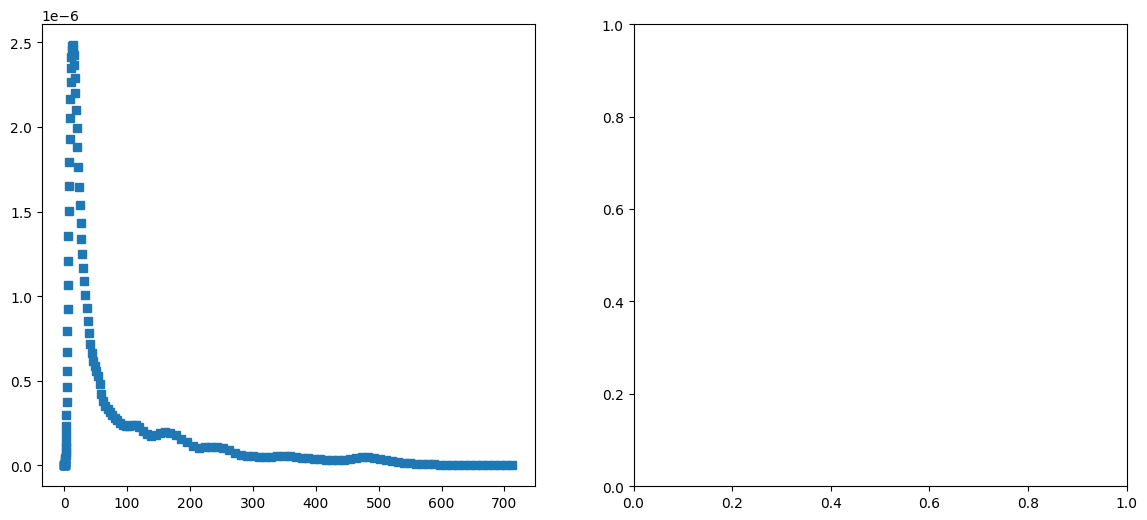

In [60]:
nu = 1.25e-5
uTau = 0.045
yplus = crd_y*uTau/nu
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axs[0].plot(yplus, mse_y_HIT[0], 's', label="HIT")
#axs[0].plot(crd_y, mse_y_off_bl_6x_6x, 'o', label="off_bl_6x_6x")
#axs[0].plot(crd_y, mse_y_off_bl_3x_6x, 'o', label="off_bl_3x_6x")
axs[1].plot(yplus, mse_y_HIT[1], 's', label="HIT_11")
#axs[1].plot(crd_y, cc_y_off_bl_6x_6x, 'o', label="off_bl_6x")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
#axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[0].grid()
axs[1].grid()
fig.tight_layout(pad=3.0)
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('$y^+$')
axs[0].set_title('Mean Squared Error')
axs[0].legend()
axs[1].set_ylabel('Correlation Coefficient')
axs[1].set_xlabel('$y^+$')
axs[1].set_title('Correlation Coefficient')
axs[1].legend()
#plt.savefig(fig_name+"_yerrors.png", dpi='figure', format="png")
plt.show()